### Classification Project
### Team 06
### Members

* 202418006
* 202418008
* 202418012
* 202418045

### Problem Formulation

This project aims to apply Clustering based on features such as Energy, loudness and danceability. These insights in future will help the creation of personalized music recommendations tailored to individual emotional needs, enhancing the effectiveness of music-based interventions.

In [218]:
!pip install kneed

### Importing libraries and tools

In [219]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

## Data Preprocessing

In [220]:
def prepare_df(csv_file):
    df = pd.read_csv(csv_file)
    df_main = df.copy()
    df_main.columns = [x.strip() for x in df_main.columns]
    df_main = df_main.set_index(['name','artist'])
    df_main = df_main.drop(columns=['key','duration_ms','type', 'id', 'html','Unnamed: 0'])
    return df_main

In [221]:
df = prepare_df('/content/df_audio_features_5000.xls')

In [222]:
df.shape

(5235, 11)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5235 entries, ('Se Eu Quiser Falar Com Deus                                                                                                                                                      ', 'Gilberto Gil                                    ') to ('Ravel: Boléro, M. 81                                                                                                                                                           ', 'Maurice Ravel                                   ')
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5235 non-null   float64
 1   energy            5235 non-null   float64
 2   loudness          5235 non-null   float64
 3   mode              5235 non-null   int64  
 4   speechiness       5235 non-null   float64
 5   acousticness      5235 non-null   float64
 6   instrumentalness  5235 non-null   float64
 7   livene

### Exploratory Data Analysis

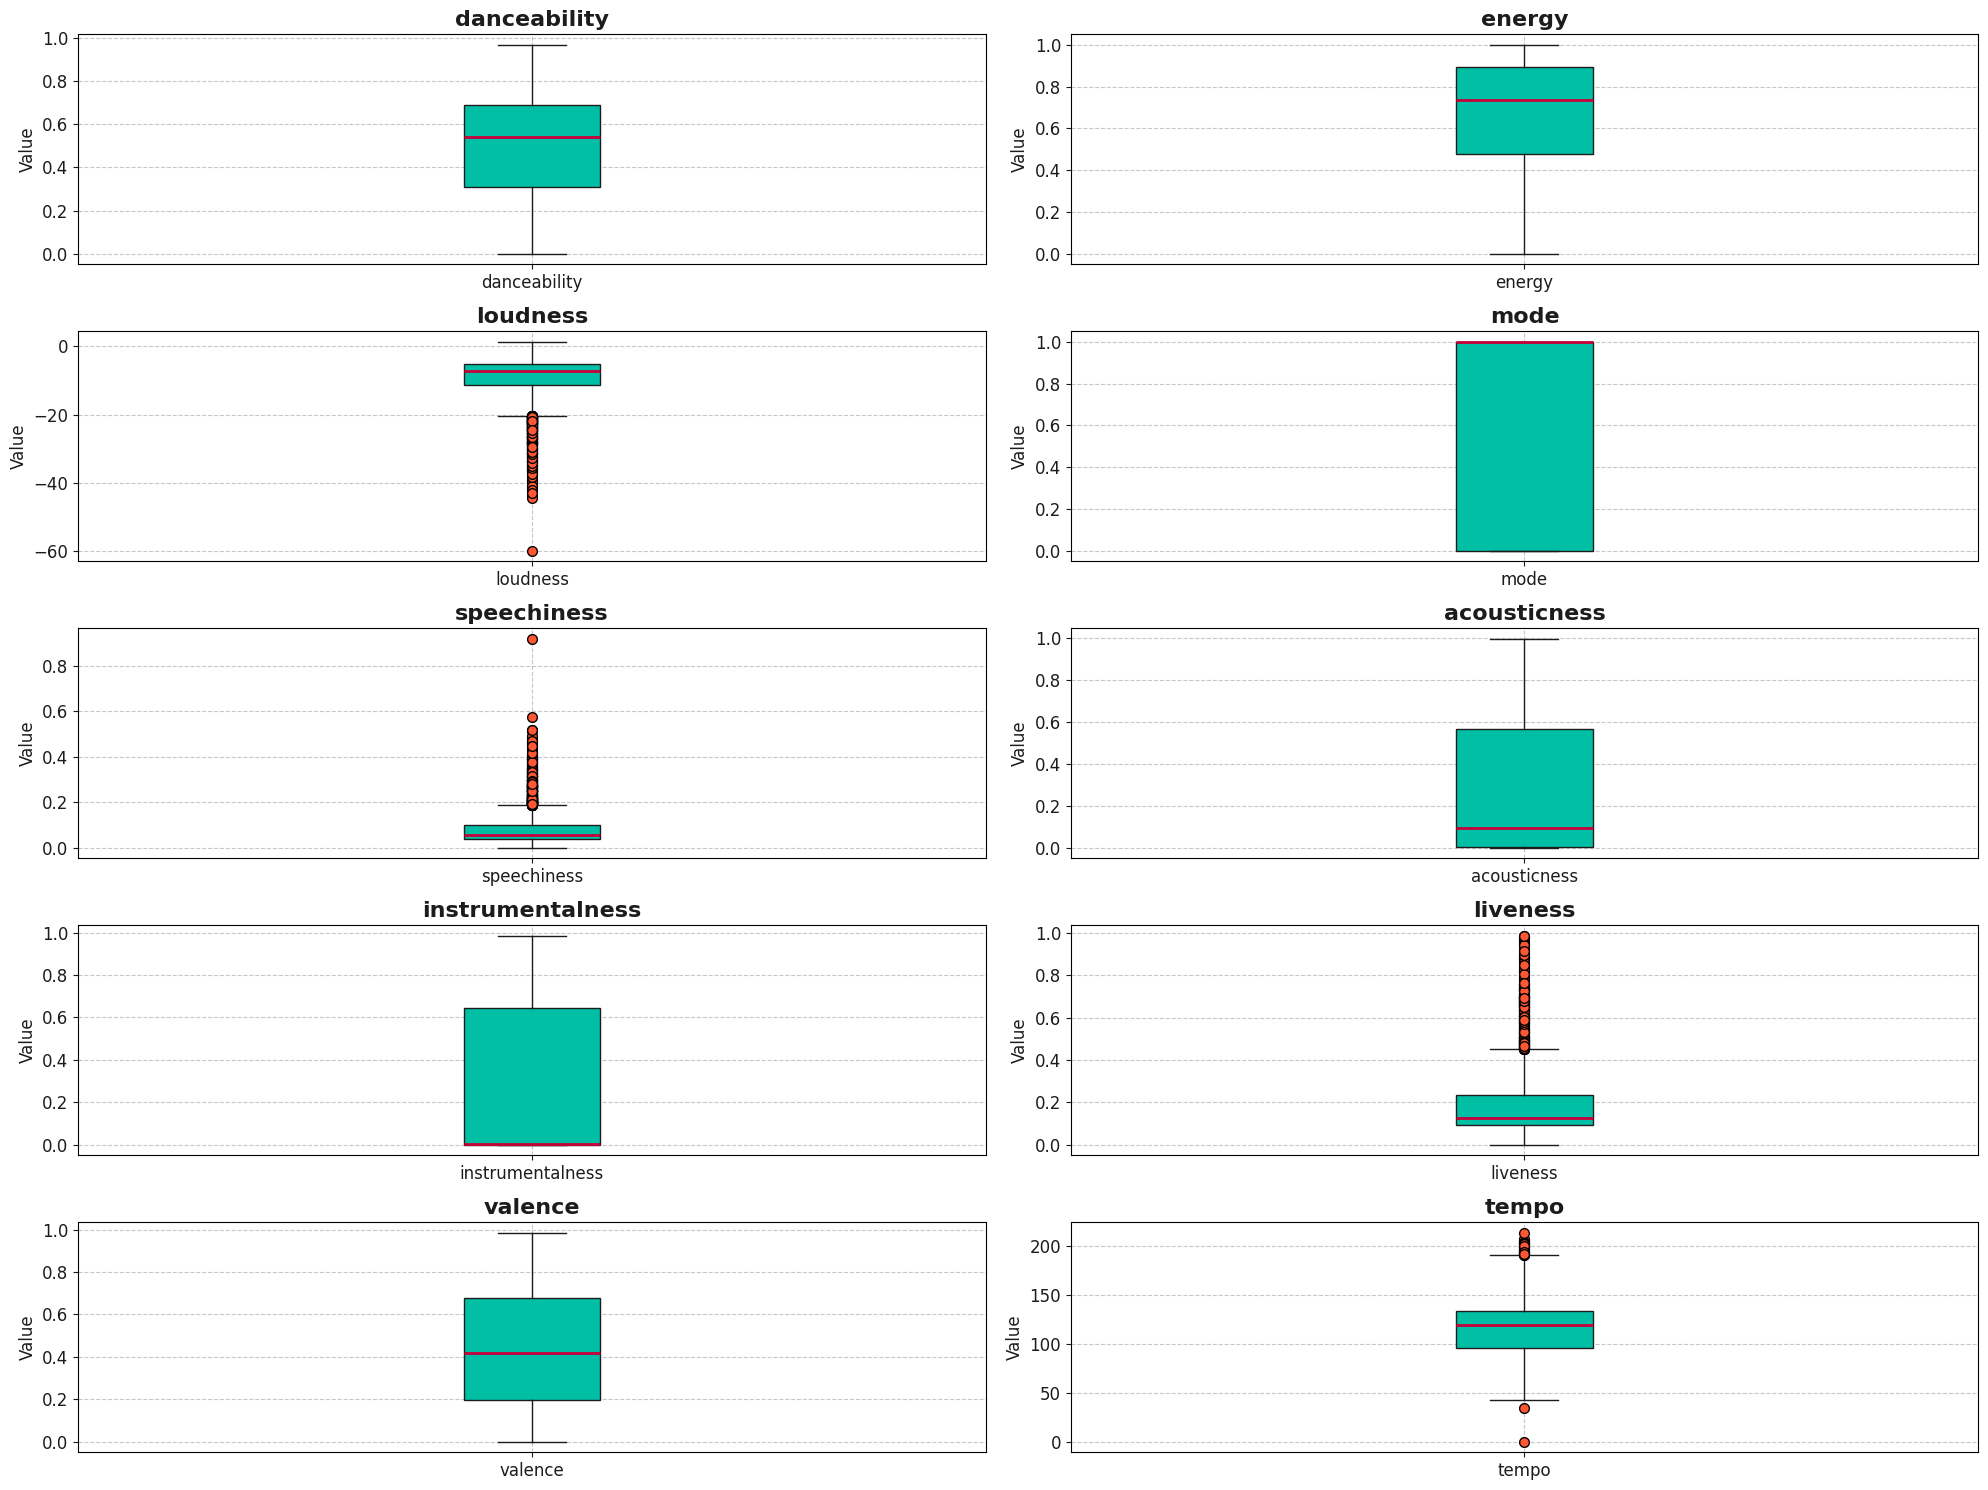

In [224]:
columns = ['danceability', 'energy', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence',
           'tempo']

n_rows = 5
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(columns):
    if i < len(columns):
        df.boxplot(column=col, ax=axes[i], color='#00BFA5', patch_artist=True,
                   boxprops=dict(facecolor='#00BFA5', color='#1C1C1C'),
                   whiskerprops=dict(color='#1C1C1C'),
                   capprops=dict(color='#1C1C1C'),
                   flierprops=dict(markerfacecolor='#FF5733', marker='o', markersize=7),
                   medianprops=dict(color='#C70039', linewidth=2))
        axes[i].set_title(col, fontsize=16, fontweight='bold', color='#1C1C1C')
        axes[i].tick_params(axis='both', labelsize=12, colors='#1C1C1C')
        axes[i].set_xlabel('', fontsize=12, color='#1C1C1C')
        axes[i].set_ylabel('Value', fontsize=12, color='#1C1C1C')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

Features such as danceability, energy, and mode show less variability, indicating consistency across tracks.
Loudness, speechiness, and liveness display significant outliers, which could represent niche or uncommon tracks.
The data indicates a mix of studio-recorded tracks with occasional live or experimental tracks (high instrumentalness or liveness).

Seperating data for minmax Scaler

In [225]:
df_minmax = df[['danceability', 'mode','acousticness', 'instrumentalness','energy','valence']]

Seprating data for robust scaler

In [226]:
df_robust = df[list(set(df.columns) - set(df_minmax.columns))]

In [227]:
df_robust

,,speechiness,tempo,time_signature,liveness,loudness
name,artist,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.0705,110.376,4,0.9750,-13.141
Saudade De Bahia,Antônio Carlos Jobim,0.0346,125.039,4,0.1070,-12.646
"Canta Canta, Minha Gente",Martinho Da Vila,0.3470,93.698,4,0.1240,-11.048
Mulher Eu Sei,Chico César,0.0471,106.802,4,0.3860,-18.115
Rosa Morena,Kurt Elling,0.0380,120.941,4,0.1040,-19.807
...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.0473,87.906,4,0.0832,-23.390
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.0442,83.134,4,0.0694,-21.873
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.0434,71.573,3,0.0772,-42.959


Transforming data

In [228]:
def preprocessing_minmax(df):
    transformer = MinMaxScaler()
    transformer.fit(df)
    normal_df = transformer.transform(df)
    normal_df = pd.DataFrame(normal_df, index=df.index, columns=df.columns)
    return normal_df

In [229]:
minmax_df = preprocessing_minmax(df_minmax)

In [230]:
def preprocessing_robust(df):
    transformer = RobustScaler()
    transformer.fit(df)
    robust_df = transformer.transform(df)
    robust_df = pd.DataFrame(robust_df, index=df.index, columns=df.columns)
    return robust_df


In [231]:
robust_df = preprocessing_robust(df_robust)

storing prepared dataframe

In [232]:
scaled_df = pd.concat([minmax_df, robust_df], axis=1)

In [233]:
scaled_df.head()

,,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness
name,artist,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.0,0.696787,0.000060,0.2590,0.310660,0.246438,-0.232633,0.0,5.882353,-0.955541
Saudade De Bahia,Antônio Carlos Jobim,0.767322,1.0,0.217871,0.000002,0.3990,0.703553,-0.355407,0.154816,0.0,-0.124567,-0.874033
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,1.0,0.454819,0.000064,0.7300,0.918782,4.881811,-0.673325,0.0,-0.006920,-0.610901
Mulher Eu Sei,Chico César,0.729059,1.0,0.882530,0.000041,0.0502,0.531980,-0.145851,-0.327071,0.0,1.806228,-1.774576
Rosa Morena,Kurt Elling,0.673216,1.0,0.919679,0.000348,0.1190,0.408122,-0.298407,0.046532,0.0,-0.145329,-2.053186


Ploting distributions

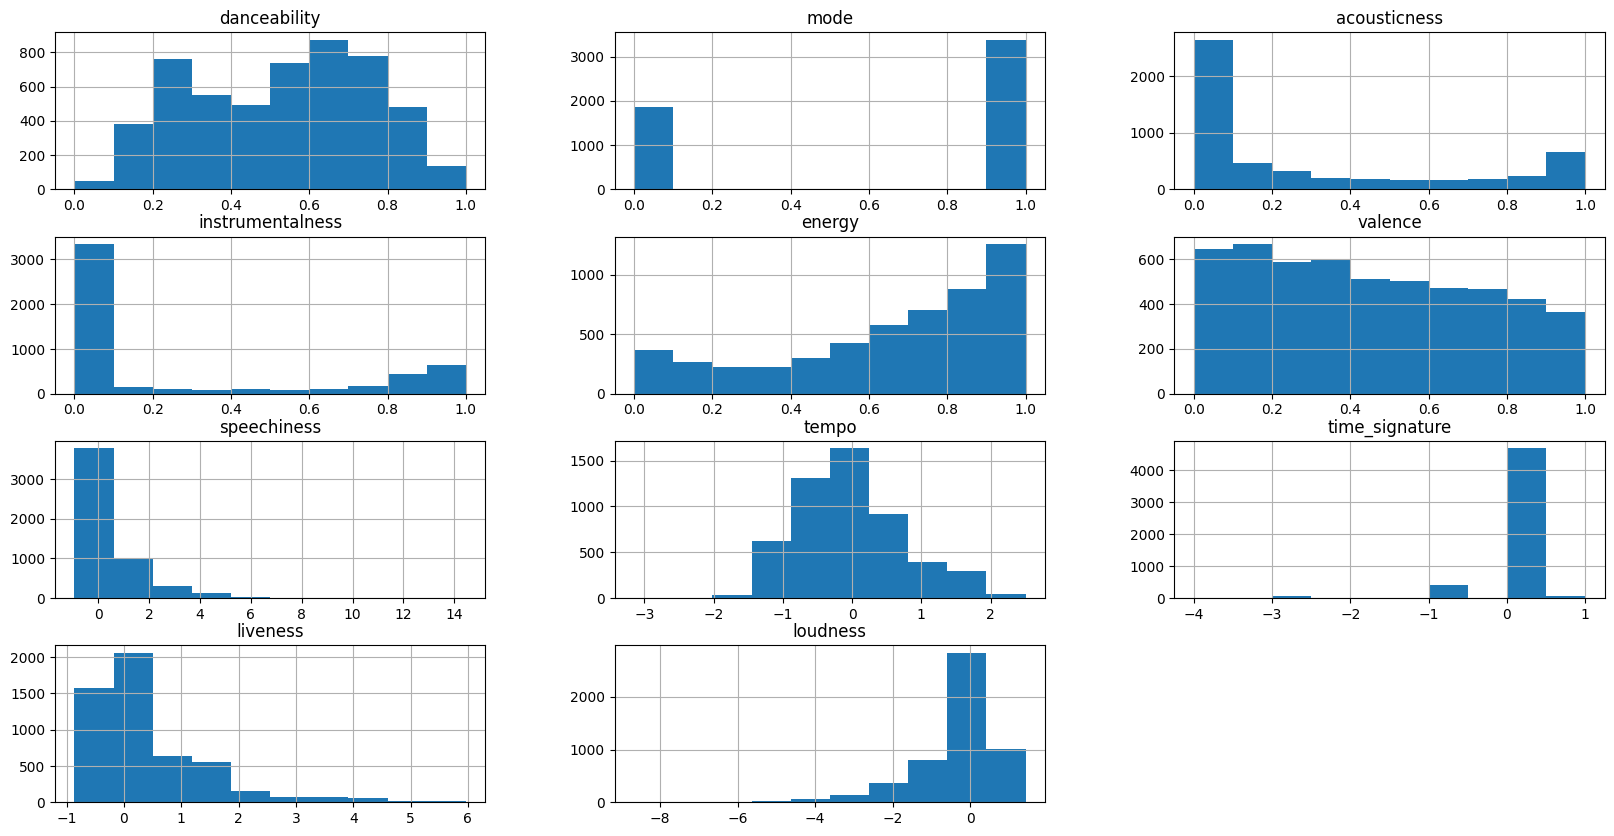

In [234]:
scaled_df.hist(figsize=(20,10))
plt.show()

After Scaling Danceability, Energy, Valence: Centered distributions with moderate to high values, showing most tracks are upbeat and lively.
Mode: Binary distribution (0 and 1) with a preference for major keys.
Acousticness, Instrumentalness, Speechiness, Liveness: Skewed towards lower values, indicating non-acoustic, vocal-dominant, studio-recorded tracks.
Tempo and Loudness: Normalized with peaks around central values, suggesting consistency.
Time Signature: Uniformly distributed, highlighting common rhythmic structures.

In [235]:
eda_df = scaled_df.copy()

Appling PCA

In [236]:
pca = PCA(n_components=0.95)


pca_result = pca.fit_transform(scaled_df)


n_components = pca.n_components_

pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

print(pca_df)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

           PC1       PC2       PC3       PC4       PC5       PC6       PC7
0     0.792519  3.365776  4.283616 -0.003536 -0.667859  0.487113 -0.322203
1    -1.003510 -0.018348 -0.405229  0.225674  0.315072  0.418330 -0.212045
2     2.915858 -3.121311  1.180639 -0.519300  0.416211  0.605100 -0.488637
3    -1.091066  0.599960  1.765466  0.045788  0.306466  0.695292 -0.412363
4    -1.815678 -0.650430  0.430747  0.442595  0.296619  0.650706 -0.328808
...        ...       ...       ...       ...       ...       ...       ...
5230 -2.294140 -1.278825  1.014691 -0.169538  0.319055  0.167072  0.299913
5231 -2.194202 -1.193293  0.770640 -0.375583  0.328568  0.212455  0.174477
5232 -4.326417 -2.685923  2.976310  0.245391  0.306434 -0.272170 -0.149767
5233 -2.931629 -1.549127  1.766928 -0.479080  0.318964  0.355940  0.216099
5234 -2.318004 -0.366704  2.147565 -0.697417  0.341681 -0.382592 -0.546205

[5235 rows x 7 columns]
Explained variance ratio: [0.34745924 0.21531147 0.19320811 0.10462374 0.04

In [237]:
scaled_df = pca_df


Computes inertia values for KMeans clustering with cluster counts from 2 to 50.

In [238]:
def find_best_clusters(scaled_df):
    inertia_list = []
    K = range(2, 51)
    for k in K:
        myKMeans = KMeans(n_clusters=k, init = 'k-means++', random_state=42)
        myKMeans.fit(scaled_df)
        inertia_list.append(myKMeans.inertia_)
    return inertia_list

In [239]:
inertia_list = find_best_clusters(scaled_df)

Generates an elbow plot for KMeans inertia values, identifies the optimal number of clusters using the knee point, and displays the result.

In [240]:
def generate_elbow_plot(inertia_list):
    plt.plot(inertia_list, 'o-', color='blue')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of KMeans")

    knee_locator = KneeLocator(range(1, len(inertia_list) + 1), inertia_list, curve='convex', direction='decreasing')
    optimal_k = knee_locator.elbow

    plt.axvline(x=optimal_k, color='red', linestyle='--')
    plt.text(optimal_k + 0.5, inertia_list[optimal_k-1], f'Optimal K={optimal_k}', color='red', fontsize=12)

    plt.show()
    print(f"Optimal K: {optimal_k}")


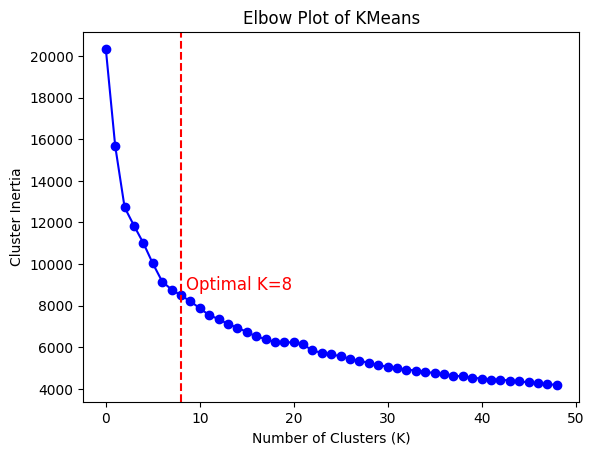

Optimal K: 8


In [241]:
generate_elbow_plot(inertia_list)

Applying KMeans clustering to the scaled data, assigns cluster labels to each data point, and returns the updated DataFrame.

In [242]:
def clustering_model(scaled_df, n_clusters):
    clustering = KMeans(n_clusters, init='k-means++', random_state=42)
    clustering.fit(scaled_df)
    scaled_df['cluster'] = clustering.predict(scaled_df)
    return scaled_df

In [243]:
cm_df = clustering_model(scaled_df, 8)

In [244]:
cm_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster
0,0.792519,3.365776,4.283616,-0.003536,-0.667859,0.487113,-0.322203,5
1,-1.003510,-0.018348,-0.405229,0.225674,0.315072,0.418330,-0.212045,6
2,2.915858,-3.121311,1.180639,-0.519300,0.416211,0.605100,-0.488637,7
3,-1.091066,0.599960,1.765466,0.045788,0.306466,0.695292,-0.412363,6
4,-1.815678,-0.650430,0.430747,0.442595,0.296619,0.650706,-0.328808,6


In [245]:
def clustering_model(scaled_df, n_clusters):
    clustering = KMeans(n_clusters, init='k-means++', random_state=42)
    clustering.fit(scaled_df)
    scaled_df['elbow_clusters'] = clustering.predict(scaled_df)
    return scaled_df

In [246]:
final_df = clustering_model(scaled_df, 15)

## Clustering

## K-means Clustering

In [247]:
def find_sil_scores(final_df, n_clusters):
    silhouette_list = []
    K = range(2, n_clusters)
    for k in K:
        myKMeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        myKMeans.fit(final_df)
        sil_score = silhouette_score(final_df, myKMeans.labels_)
        silhouette_list.append(sil_score)
    return silhouette_list

In [248]:
sil_list = find_sil_scores(final_df, 25)

In [249]:
for i in range(0,23):
    print(f"n_clusters:{i+2}, Silhouette Score: {sil_list[i]}")

n_clusters:2, Silhouette Score: 0.5112517437684418
n_clusters:3, Silhouette Score: 0.4095670401563499
n_clusters:4, Silhouette Score: 0.4122802808763548
n_clusters:5, Silhouette Score: 0.42960409107245245
n_clusters:6, Silhouette Score: 0.45338122966475664
n_clusters:7, Silhouette Score: 0.48083855509023016
n_clusters:8, Silhouette Score: 0.5348595497723877
n_clusters:9, Silhouette Score: 0.572653887378969
n_clusters:10, Silhouette Score: 0.5933294298793637
n_clusters:11, Silhouette Score: 0.6085968028322275
n_clusters:12, Silhouette Score: 0.608600325002487
n_clusters:13, Silhouette Score: 0.5839618871452367
n_clusters:14, Silhouette Score: 0.5664038311945137
n_clusters:15, Silhouette Score: 0.5447405448220268
n_clusters:16, Silhouette Score: 0.5115950576869288
n_clusters:17, Silhouette Score: 0.5149661458351708
n_clusters:18, Silhouette Score: 0.5155492618311708
n_clusters:19, Silhouette Score: 0.4699706187807682
n_clusters:20, Silhouette Score: 0.45903574203106146
n_clusters:21, Sil

In [250]:
myKMeans = KMeans(n_clusters=12, init='k-means++', random_state=42)
myKMeans.fit(final_df)

sil_score = silhouette_score(final_df, myKMeans.labels_)
db_score = davies_bouldin_score(final_df, myKMeans.labels_)
ch_score = calinski_harabasz_score(final_df, myKMeans.labels_)

print("K-Means Performance:")
print("Number of Clusters: 12")
print(f"Silhouette Score: {sil_score}")
print(f"Calinski-Harabasz Score: {ch_score}")
print(f"Davies-Bouldin Score: {db_score}")

K-Means Performance:
Number of Clusters: 12
Silhouette Score: 0.608600325002487
Calinski-Harabasz Score: 6440.008409536371
Davies-Bouldin Score: 0.5541955555081124


## Agglomerative Clustering

In [251]:


def agg_tuning(data, cluster_range, linkage_methods):
    results = []

    for linkage in linkage_methods:
        for n_clusters in cluster_range:

            agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            labels = agg_clustering.fit_predict(data)

            if len(set(labels)) > 1:
                silhouette = silhouette_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)

                results.append((n_clusters, linkage, silhouette, davies_bouldin, calinski_harabasz))
            else:

                results.append((n_clusters, linkage, None, None, None))

    return results

cluster_range = range(15, 25)
linkage_methods = ['ward', 'complete', 'average', 'single']

results = agg_tuning(final_df, cluster_range, linkage_methods)

print("Agglomerative Clustering Tuning Results:")
for n_clusters, linkage, silhouette, davies_bouldin, calinski_harabasz in results:
    print(f"Clusters: {n_clusters}, Linkage: {linkage}, Silhouette Score: {silhouette}, Davies-Bouldin Index: {davies_bouldin}, Calinski-Harabasz Index: {calinski_harabasz}")

Agglomerative Clustering Tuning Results:
Clusters: 15, Linkage: ward, Silhouette Score: 0.5403395846546618, Davies-Bouldin Index: 0.8979757829559379, Calinski-Harabasz Index: 7536.400390005518
Clusters: 16, Linkage: ward, Silhouette Score: 0.5331550377030582, Davies-Bouldin Index: 0.9850245759085106, Calinski-Harabasz Index: 7200.935632568016
Clusters: 17, Linkage: ward, Silhouette Score: 0.4197902799830487, Davies-Bouldin Index: 1.1361552708131566, Calinski-Harabasz Index: 6885.715308894804
Clusters: 18, Linkage: ward, Silhouette Score: 0.40309103200758417, Davies-Bouldin Index: 1.2085677038534512, Calinski-Harabasz Index: 6608.852812619916
Clusters: 19, Linkage: ward, Silhouette Score: 0.4038323468312373, Davies-Bouldin Index: 1.20461475101765, Calinski-Harabasz Index: 6359.733376797138
Clusters: 20, Linkage: ward, Silhouette Score: 0.36475925092009726, Davies-Bouldin Index: 1.2851424540053662, Calinski-Harabasz Index: 6131.5256839025205
Clusters: 21, Linkage: ward, Silhouette Score:

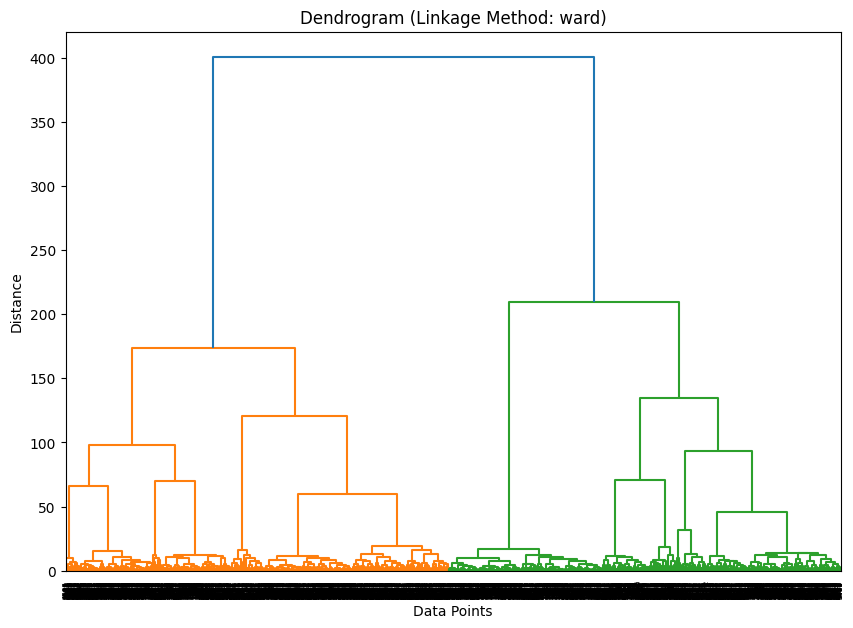

In [252]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(data, method):
    Z = linkage(data, method=method)
    plt.figure(figsize=(10, 7))
    plt.title(f"Dendrogram (Linkage Method: {method})")
    dendrogram(Z)
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.show()
plot_dendrogram(final_df, method='ward')


### Best results for Agglomerative Clustering:
Clusters: 24, Linkage: average

Silhouette Score: 0.641576342160276

Davies-Bouldin Index: 0.5668082635582375

Calinski-Harabasz Index: 3994.0422028908133

## DBSCAN

In [253]:
dbscan = DBSCAN(eps=1.5, min_samples=15)
dbscan_labels = dbscan.fit_predict(final_df)

final_df['dbscan_labels'] = dbscan_labels

cluster_counts = final_df['dbscan_labels'].value_counts()
print("\nDBSCAN Cluster Counts:\n", cluster_counts)

noise_count = cluster_counts.get(-1, 0)
total_samples = len(final_df)
noise_proportion = noise_count / total_samples
print(f"\nNoise Proportion (-1 class): {noise_count}/{total_samples} ({noise_proportion:.2%})")


DBSCAN Cluster Counts:
 dbscan_labels
 5     1244
 4     1028
 3      896
 6      489
 2      461
 0      314
 7      205
 8      173
 1      165
-1      114
 11      89
 9       41
 10      16
Name: count, dtype: int64

Noise Proportion (-1 class): 114/5235 (2.18%)


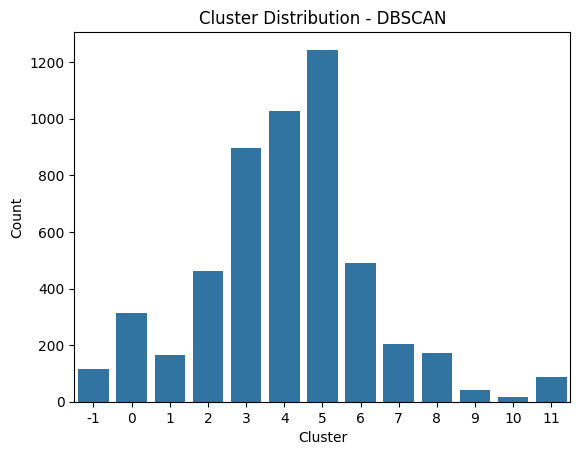

In [254]:
sns.countplot(x='dbscan_labels', data=final_df)
plt.title("Cluster Distribution - DBSCAN")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [255]:
print("DBSCAN Performance:")
print("Epsilon: 1.5")
print("Min Samples: 15")
print("Number of Clusters: 12")
valid_labels = final_df['dbscan_labels'] != -1
if valid_labels.any():
    score = silhouette_score(final_df[valid_labels], dbscan_labels[valid_labels])
    print("\nDBSCAN Silhouette Score:", score)
else:
    print("\nNo valid clusters found by DBSCAN.")


db_score = davies_bouldin_score(final_df[valid_labels],dbscan_labels[valid_labels])
ch_score = calinski_harabasz_score(final_df[valid_labels], dbscan_labels[valid_labels])

print(f"Calinski-Harabasz Score: {ch_score}")
print(f"Davies-Bouldin Score: {db_score}")

DBSCAN Performance:
Epsilon: 1.5
Min Samples: 15
Number of Clusters: 12

DBSCAN Silhouette Score: 0.6483354544579168
Calinski-Harabasz Score: 8195.954617422818
Davies-Bouldin Score: 0.4808604470263311


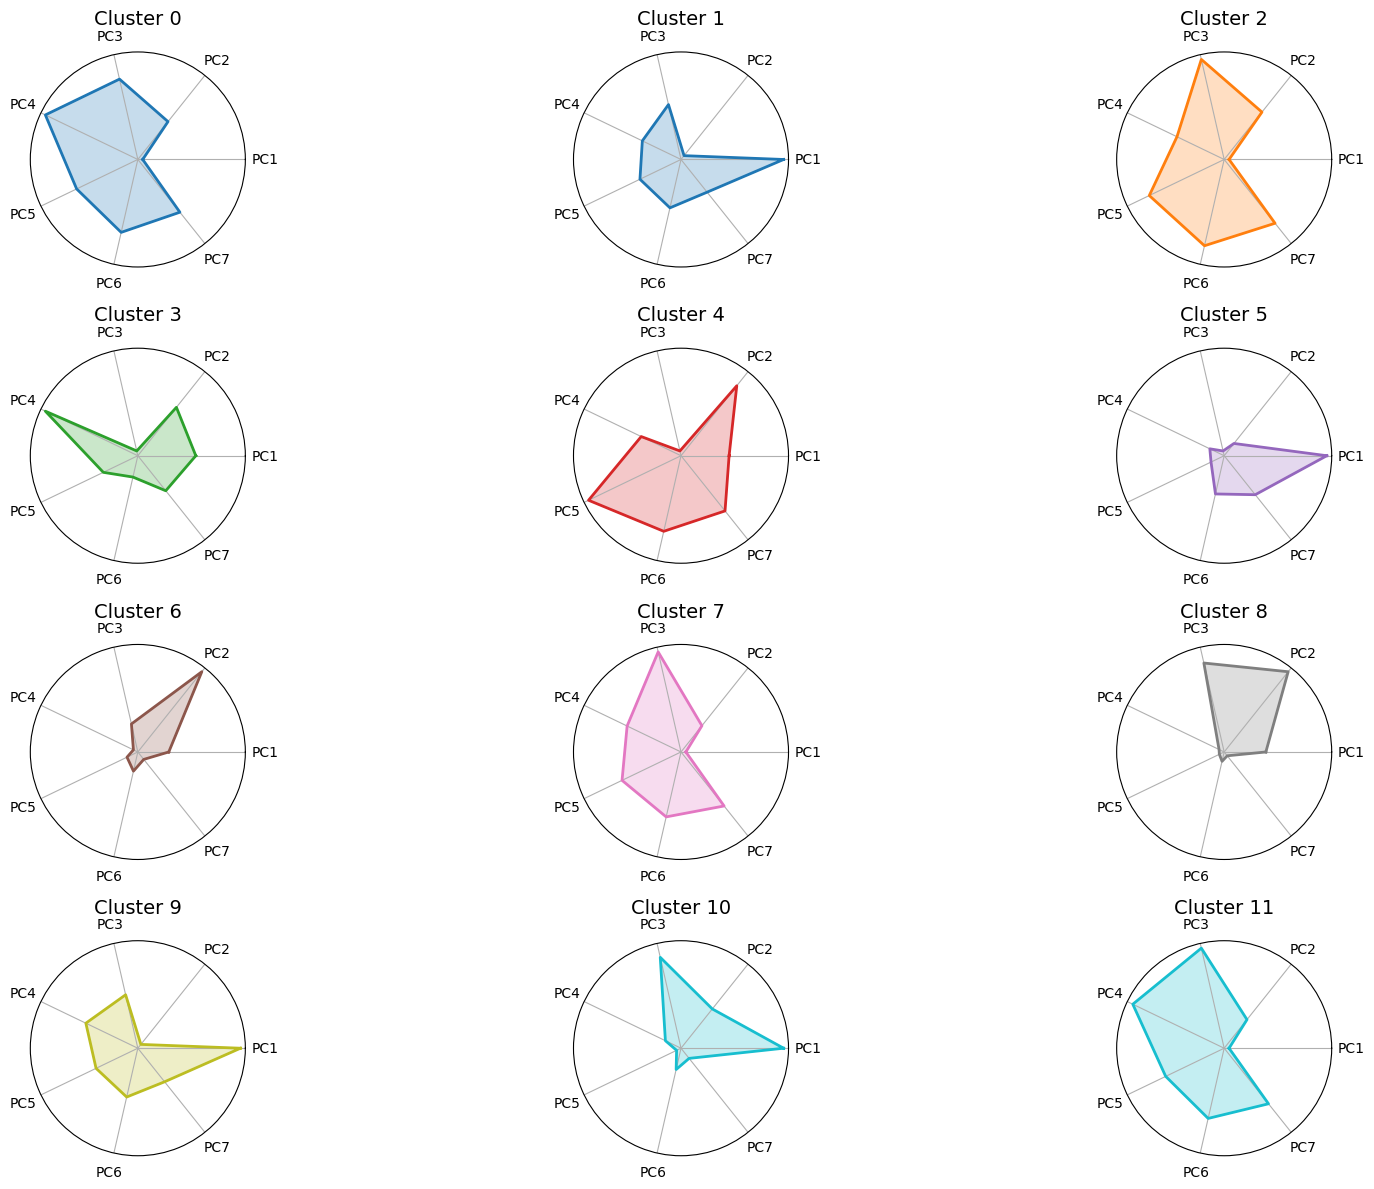

In [256]:
features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
cluster_labels = sorted(label for label in final_df['dbscan_labels'].unique() if label != -1)

colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_labels)))
n_clusters = len(cluster_labels)

fig, axes = plt.subplots(
    nrows=int(np.ceil(n_clusters / 3)), ncols=3,
    figsize=(18, 12), subplot_kw=dict(polar=True)
)

axes = axes.flatten()

for idx, (cluster_label, color) in enumerate(zip(cluster_labels, colors)):
    cluster_data = final_df[final_df['dbscan_labels'] == cluster_label][features].mean()
    values = cluster_data.tolist()
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]

    ax = axes[idx]
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2)
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=10)
    ax.set_title(f"Cluster {cluster_label}", fontsize=14, pad=20)

for ax in axes[len(cluster_labels):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


Each cluster has a unique profile based on principal component (PC) values, showing distinct user groups with different characteristics. Some clusters are defined by specific PCs (e.g., Cluster 1 by PC2, Cluster 3 by PC4), while others share patterns across PCs (e.g., Clusters 0 and 8 both emphasize PC2 and PC3). These profiles can help in targeted marketing, personalized recommendations, and user segmentation by tailoring content to match each group's characteristics. Further analysis could clarify the meaning of each PC, enhancing the model's interpretability and application.

## Cluster Analysis

In [262]:
eda_df['dbscan_labels'] = dbscan_labels
eda_df.head()

,,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
name,artist,,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.0,0.696787,0.000060,0.2590,0.310660,0.246438,-0.232633,0.0,5.882353,-0.955541,8
Saudade De Bahia,Antônio Carlos Jobim,0.767322,1.0,0.217871,0.000002,0.3990,0.703553,-0.355407,0.154816,0.0,-0.124567,-0.874033,0
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,1.0,0.454819,0.000064,0.7300,0.918782,4.881811,-0.673325,0.0,-0.006920,-0.610901,1
Mulher Eu Sei,Chico César,0.729059,1.0,0.882530,0.000041,0.0502,0.531980,-0.145851,-0.327071,0.0,1.806228,-1.774576,2
Rosa Morena,Kurt Elling,0.673216,1.0,0.919679,0.000348,0.1190,0.408122,-0.298407,0.046532,0.0,-0.145329,-2.053186,0


In [263]:
for i in range(12):
    print('Cluster:', i)
    display(eda_df[eda_df['dbscan_labels'] == i].describe())
    print('\n')
    eda_df['dbscan_labels']

Cluster: 0


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.0
mean,0.468580,0.671975,0.760937,0.498969,0.250587,0.322401,-0.150955,0.398998,-0.159236,0.012507,-1.537548,0.0
std,0.182929,0.470244,0.312132,0.419282,0.194478,0.243199,0.277139,0.474282,0.415507,0.387752,0.472766,0.0
min,0.083454,0.000000,0.000001,0.000000,0.012100,0.022437,-0.496228,-0.435143,-1.000000,-0.633218,-2.691421,0.0
25%,0.329886,0.000000,0.663153,0.001388,0.116500,0.128173,-0.338642,0.111197,0.000000,-0.187370,-1.901943,0.0
50%,0.468459,1.000000,0.912149,0.660406,0.194000,0.257868,-0.222967,0.303237,0.000000,-0.096886,-1.565207,0.0
75%,0.591779,1.000000,0.979418,0.911675,0.321750,0.462944,-0.061190,0.553759,0.000000,0.069204,-1.152890,0.0
max,0.964840,1.000000,0.998996,0.992893,0.964000,1.000000,1.713328,2.214374,1.000000,2.069204,-0.485757,0.0




Cluster: 1


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.0
mean,0.668779,0.587879,0.135448,0.078372,0.734473,0.536776,3.874927,-0.072812,-0.012121,0.223278,0.157821,1.0
std,0.235938,0.493715,0.167143,0.232793,0.173718,0.273359,0.531922,0.881492,0.220528,0.685251,0.459669,0.0
min,0.124095,0.000000,0.000002,0.000000,0.215000,0.032386,3.104778,-1.295759,-1.000000,-0.698962,-1.372139,1.0
25%,0.519131,0.000000,0.016165,0.000000,0.620000,0.323858,3.456832,-0.690871,0.000000,-0.290657,-0.010374,1.0
50%,0.748707,1.000000,0.060341,0.000000,0.730000,0.618274,3.741827,-0.499379,0.000000,0.027682,0.249300,1.0
75%,0.844881,1.000000,0.188755,0.001157,0.862000,0.763452,4.261526,0.549108,0.000000,0.539792,0.443438,1.0
max,0.971044,1.000000,0.664659,0.963452,0.998000,0.977665,5.435038,2.234007,1.000000,2.553633,1.182282,1.0




Cluster: 2


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.0
mean,0.456834,0.689805,0.659640,0.374188,0.347600,0.367433,-0.131879,-0.715559,-0.078091,0.125596,-1.196663,2.0
std,0.204601,0.463076,0.358014,0.413352,0.235045,0.264074,0.331753,0.374083,0.382181,0.482280,0.445900,0.0
min,0.068149,0.000000,0.000000,0.000000,0.030400,0.031675,-0.504610,-1.634773,-1.000000,-0.662976,-2.389429,2.0
25%,0.274043,0.000000,0.411647,0.000120,0.168000,0.140102,-0.358759,-1.016171,0.000000,-0.180623,-1.519019,2.0
50%,0.459152,1.000000,0.825301,0.085888,0.286000,0.307614,-0.236379,-0.718827,0.000000,-0.034602,-1.096163,2.0
75%,0.613237,1.000000,0.945783,0.870051,0.462000,0.559391,-0.025147,-0.420478,0.000000,0.325260,-0.855755,2.0
max,0.962771,1.000000,0.997992,0.975635,0.985000,0.993909,1.327745,0.158171,1.000000,1.806228,-0.259839,2.0




Cluster: 3


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.0
mean,0.421659,0.715402,0.151213,0.338376,0.792568,0.437549,0.392968,0.810909,-0.087054,0.493480,-0.056481,3.0
std,0.202808,0.451475,0.255580,0.394676,0.194823,0.277112,0.573253,0.707244,0.312156,0.795971,0.482687,0.0
min,0.067011,0.000000,0.000000,0.000000,0.102000,0.030863,-0.531433,-1.167816,-1.000000,-0.789619,-1.975795,3.0
25%,0.248190,0.000000,0.000031,0.000005,0.677000,0.209137,-0.074183,0.457511,0.000000,-0.166090,-0.363741,3.0
50%,0.382110,1.000000,0.004548,0.051777,0.865500,0.376142,0.360436,0.867274,0.000000,0.211073,0.001400,3.0
75%,0.584281,1.000000,0.187249,0.811675,0.945000,0.660914,0.757754,1.367876,0.000000,1.162630,0.277540,3.0
max,0.935884,1.000000,0.994980,0.983756,0.999000,1.000000,2.518022,2.505219,1.000000,2.636678,1.338054,3.0




Cluster: 4


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,1028.000000,1028.0,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.0
mean,0.619478,1.0,0.193132,0.113350,0.713654,0.554279,-0.095905,-0.203564,-0.018482,-0.085684,0.094423,4.0
std,0.183248,0.0,0.243670,0.261191,0.172115,0.261291,0.354927,0.449794,0.208507,0.318701,0.377851,0.0
min,0.122027,1.0,0.000000,0.000000,0.189000,0.031675,-0.553227,-1.598467,-1.000000,-0.727336,-0.816236,4.0
25%,0.525336,1.0,0.007199,0.000000,0.586000,0.335025,-0.377200,-0.584133,0.000000,-0.317820,-0.174255,4.0
50%,0.650465,1.0,0.085040,0.000036,0.737500,0.559391,-0.209556,-0.140798,0.000000,-0.145329,0.109666,4.0
75%,0.753878,1.0,0.298695,0.014619,0.857000,0.777665,0.115675,0.179713,0.000000,0.117647,0.379055,4.0
max,0.994829,1.0,0.964859,0.986802,0.992000,0.992893,0.975692,0.709024,1.000000,0.906574,1.397332,4.0




Cluster: 5


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.0
mean,0.571303,0.320740,0.126582,0.202602,0.797536,0.454022,0.924600,-0.176823,-0.044212,0.078561,0.164456,5.0
std,0.243631,0.466949,0.202157,0.331386,0.168186,0.279861,1.021232,0.564040,0.231419,0.525801,0.397068,0.0
min,0.063702,0.000000,0.000000,0.000000,0.205000,0.030761,-0.544845,-1.753891,-1.000000,-0.703114,-1.330973,5.0
25%,0.314374,0.000000,0.000163,0.000000,0.684750,0.188832,-0.060352,-0.618543,0.000000,-0.284948,-0.070105,5.0
50%,0.631851,0.000000,0.025251,0.001049,0.834500,0.437056,0.942163,-0.188810,0.000000,-0.069204,0.231681,5.0
75%,0.777663,1.000000,0.175954,0.296701,0.948000,0.690355,1.730092,0.214810,0.000000,0.325260,0.438828,5.0
max,1.000000,1.000000,0.986948,0.970558,0.999000,0.990863,3.188600,2.136108,1.000000,2.664360,1.429277,5.0




Cluster: 6


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.0
mean,0.624530,0.625767,0.174037,0.076692,0.765166,0.581745,-0.085732,0.019509,-0.016360,1.486276,0.212693,6.0
std,0.160887,0.484420,0.233334,0.210361,0.158374,0.239369,0.318461,0.532862,0.155955,0.456529,0.399663,0.0
min,0.117890,0.000000,0.000001,0.000000,0.112000,0.062741,-0.556580,-1.451367,-1.000000,0.692042,-1.048576,6.0
25%,0.532575,0.000000,0.008163,0.000000,0.673000,0.390863,-0.326907,-0.374501,0.000000,1.148789,-0.031121,6.0
50%,0.645295,1.000000,0.061647,0.000018,0.798000,0.579695,-0.165968,0.127784,0.000000,1.432526,0.262309,6.0
75%,0.743537,1.000000,0.251004,0.006386,0.885000,0.771574,0.078793,0.294913,0.000000,1.743945,0.491849,6.0
max,0.968976,1.000000,0.978916,0.960406,0.993000,0.993909,1.009220,1.721971,1.000000,2.809689,1.120534,6.0




Cluster: 7


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.0
mean,0.266120,0.634146,0.952380,0.811010,0.062168,0.115905,-0.177450,-1.114274,-0.312195,-0.093149,-3.251299,7.0
std,0.137629,0.482848,0.087772,0.247382,0.068636,0.118660,0.196403,0.328457,0.524028,0.390016,0.956243,0.0
min,0.061634,0.000000,0.130522,0.000001,0.000020,0.019898,-0.476111,-2.228141,-1.000000,-0.525952,-6.103738,7.0
25%,0.145812,0.000000,0.940763,0.825381,0.013200,0.038680,-0.286672,-1.325327,-1.000000,-0.271972,-3.796806,7.0
50%,0.257497,1.000000,0.985944,0.915736,0.045200,0.073198,-0.226320,-1.170273,0.000000,-0.184083,-2.971019,7.0
75%,0.362978,1.000000,0.995984,0.938071,0.079200,0.148223,-0.135792,-0.942212,0.000000,-0.089965,-2.468961,7.0
max,0.673216,1.000000,1.000000,1.000000,0.537000,0.824365,0.791282,-0.300806,1.000000,1.993080,-2.002635,7.0




Cluster: 8


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.0
mean,0.531103,0.624277,0.260932,0.169527,0.731512,0.463357,0.244461,0.008374,-0.034682,3.917355,-0.050443,8.0
std,0.181301,0.485715,0.320619,0.314745,0.244673,0.267530,0.566592,0.644384,0.261835,0.832851,0.746810,0.0
min,0.097001,0.000000,0.000002,0.000000,0.062200,0.031472,-0.479464,-1.256599,-1.000000,2.615917,-2.649267,8.0
25%,0.402275,0.000000,0.004177,0.000000,0.625000,0.251777,-0.211232,-0.479509,0.000000,3.259516,-0.325704,8.0
50%,0.562565,1.000000,0.057028,0.000141,0.815000,0.441624,0.112322,0.141313,0.000000,3.806228,0.135518,8.0
75%,0.671148,1.000000,0.489960,0.104569,0.920000,0.690355,0.569992,0.285797,0.000000,4.256055,0.470278,8.0
max,0.891417,1.000000,0.988956,0.959391,1.000000,0.984772,1.813915,2.069468,1.000000,5.965398,0.990120,8.0




Cluster: 9


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.000000,41.0
mean,0.610513,0.585366,0.145584,0.043456,0.769902,0.503922,5.551162,0.907360,0.0,-0.013453,0.222946,9.0
std,0.181363,0.498779,0.148409,0.176031,0.154467,0.264342,0.578609,0.803789,0.0,0.489445,0.371744,0.0
min,0.205791,0.000000,0.000107,0.000000,0.425000,0.038782,4.680637,-0.607953,0.0,-0.570242,-0.597234,9.0
25%,0.502585,0.000000,0.016968,0.000000,0.706000,0.353299,5.116513,0.181345,0.0,-0.292042,-0.006587,9.0
50%,0.627715,1.000000,0.129518,0.000004,0.787000,0.570558,5.451802,1.342344,0.0,-0.131488,0.313190,9.0
75%,0.724922,1.000000,0.189759,0.000170,0.899000,0.730964,5.820620,1.582138,0.0,0.027682,0.530216,9.0
max,0.991727,1.000000,0.535141,0.848731,0.989000,0.914721,6.826488,2.183115,0.0,1.598616,0.701136,9.0




Cluster: 10


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.000000,16.000000,16.0
mean,0.618149,0.187500,0.114424,0.054335,0.845375,0.476472,2.690905,0.086658,0.0,3.813581,0.273907,10.0
std,0.175826,0.403113,0.137678,0.156286,0.120100,0.237932,0.531787,0.621525,0.0,0.630426,0.329298,0.0
min,0.179938,0.000000,0.000002,0.000000,0.610000,0.039797,1.931266,-0.921284,0.0,2.768166,-0.650914,10.0
25%,0.528438,0.000000,0.015379,0.000000,0.777250,0.346447,2.249790,-0.238651,0.0,3.330450,0.125638,10.0
50%,0.678387,0.000000,0.048795,0.000005,0.896000,0.505076,2.719195,0.178689,0.0,3.795848,0.333855,10.0
75%,0.732161,0.000000,0.190261,0.006282,0.920500,0.593909,2.903604,0.262049,0.0,4.297578,0.451589,10.0
max,0.797311,1.000000,0.445783,0.619289,0.995000,0.824365,3.725063,1.383723,0.0,4.837370,0.689610,10.0




Cluster: 11


,danceability,mode,acousticness,instrumentalness,energy,valence,speechiness,tempo,time_signature,liveness,loudness,dbscan_labels
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0
mean,0.334929,0.561798,0.952168,0.842101,0.061846,0.167530,-0.174407,0.481913,-0.292135,-0.078986,-3.278597,11.0
std,0.130286,0.498978,0.104100,0.237835,0.058615,0.140554,0.153004,0.482719,0.526615,0.351488,0.689618,0.0
min,0.143744,0.000000,0.280120,0.002437,0.002360,0.032893,-0.432523,-0.251500,-1.000000,-0.505190,-5.726824,11.0
25%,0.206825,0.000000,0.961847,0.869036,0.021200,0.049340,-0.268231,0.135500,-1.000000,-0.238062,-3.757286,11.0
50%,0.335057,1.000000,0.989960,0.921827,0.046000,0.110660,-0.212909,0.443467,0.000000,-0.159170,-3.145562,11.0
75%,0.435367,1.000000,0.996988,0.948223,0.083200,0.274112,-0.129086,0.695970,0.000000,-0.062284,-2.761568,11.0
max,0.619442,1.000000,1.000000,0.992893,0.362000,0.563452,0.395641,1.608561,1.000000,1.356401,-2.247489,11.0


In [269]:
def plot_violin_filtered(data, label_col, num_cols, nrows=1, figsize=(16, 70)):

    data = data[data[label_col] != -1]

    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=figsize)

    if nrows == 1:
        axs = [axs]

    for i, col in enumerate(num_cols):
        q1, q3 = np.quantile(data[col].dropna(), [0.25, 0.75])
        upper_bound = q3 + 1.5 * (q3 - q1)

        filtered_data = data.loc[data[col] <= upper_bound, [label_col, col]].dropna()

        if not filtered_data.empty:
            sns.violinplot(data=filtered_data, x=label_col, y=col, ax=axs[i])
        else:
            axs[i].text(0.5, 0.5, f'No Data for {col}',
                        horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
            axs[i].set_title(f"No valid data for {col}")

    plt.tight_layout()
    plt.show()


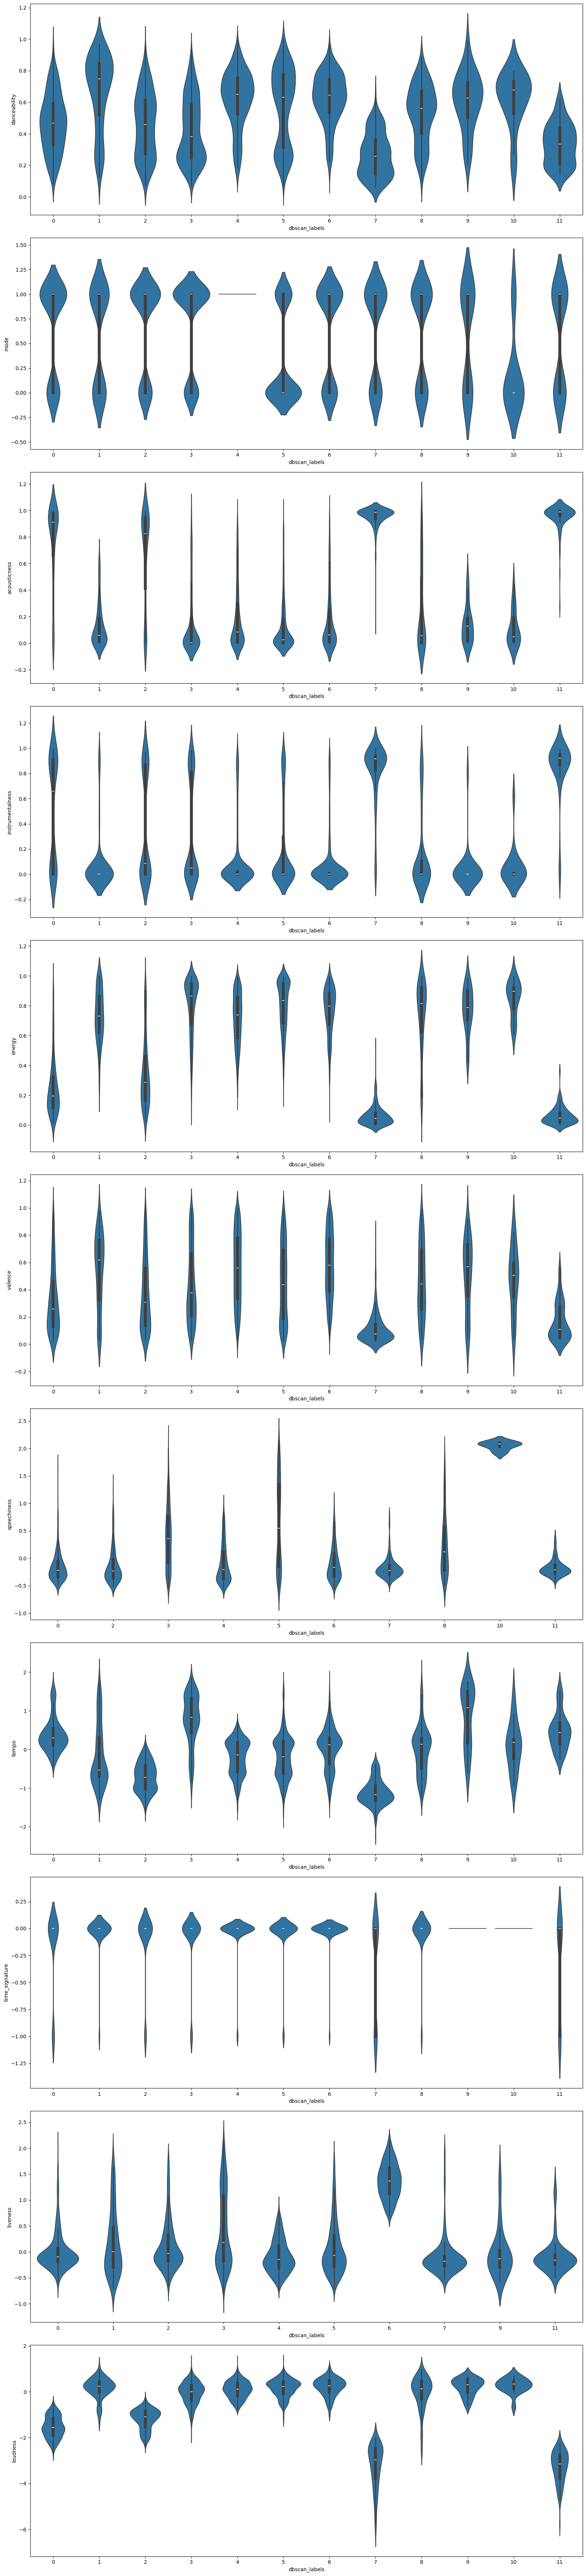

In [270]:
num_columns = eda_df.columns.drop('dbscan_labels')
plot_violin_filtered(eda_df, 'dbscan_labels', num_columns, nrows=len(num_columns), figsize=(16, 70))

## Cluster Analysis

From the above Graphs we observe clusters formed has unique features and each of them are suitable for particular ocassions for example

Cluster 2: It has High danceability, energy, and positivity; low acousticness.
Perfect for upbeat party playlists.

Cluster 4: has High acousticness, low energy, and neutral mood.
Great for mellow, acoustic-focused playlists.

Cluster 6: High acousticness, low energy, and sad mood.
Ideal for emotional or reflective acoustic playlists.

Cluster 11: High danceability, energy, and positivity; low acousticness.
Perfect for high-energy dance playlists.

Cluster 9: Mellow, less danceable, mixed acousticness, and sad mood.
Good for introspective or calming playlists.

### INSIGTHS

 1.) Clustering algorithms (K-Means, DBSCAN, Agglomerative) revealed distinct groups of songs with shared audio characteristics.    

2.) PCA helped reduce the complexity of the feature space, making it easier to visualize and interpret the clusters, enhancing the understanding of song groupings based on audio features.

3.)  Min-Max scaling normalized the features to a fixed range (0 to 1), making algorithms like K-Means more effective by ensuring all features contributed equally. This likely improved the cohesion and separation of clusters.

### Further scope


Clustering for song recommendations can be further enhanced by incorporating a wide range of audio and contextual features, such as tempo, rhythm, mood, lyrics, and even metadata like artist collaborations or release year. By grouping songs into clusters based on these attributes, the system can recommend tracks that align with a user’s listening preferences while also introducing diverse options from less explored clusters. Additionally, clustering can adapt dynamically to trends, enabling recommendations that reflect both individual tastes and evolving popular patterns, ensuring a more personalized and engaging music discovery experience.

### Refrences  

https://iieta.org/journals/ria/paper/10.18280/ria.380138

Hands on ML

https://scikit-learn.org/stable/

### Pseduo Code

Algorithm K-Means Clustering:

1. Initialize centroids
   - Randomly select k data points from the dataset as initial centroids.

2. Repeat until convergence:
   a. Assignment step:
      - For each data point in the dataset:
        i.  Calculate the distance between the data point and each centroid.
        ii. Assign the data point to the nearest centroid.
   
   b. Update step:
      - For each centroid:
        i.  Calculate the new centroid by taking the mean of all data points assigned to it.

3. Convergence criteria:
   - Check if the centroids have stopped moving (i.e., the changes in centroid positions are below a certain threshold).
   - If centroids have converged, terminate the algorithm.
   - If not, repeat steps 2a and 2b.

End Algorithm

## Agglomerative Clustering

given a dataset (d1, d2, d3, ....dN) of size N

 compute the distance matrix
for i=1 to N:
   
   as the distance matrix is symmetric about
   the primary diagonal so we compute only lower
   part of the primary diagonal
   
   for j=1 to i:
      dis_mat[i][j] = distance[di, dj]

each data point is a singleton cluster
repeat
   merge the two cluster having minimum distance
   update the distance matrix
until only a single cluster remains

### DBSCAN

DBSCAN(dataset, eps, MinPts){
cluster index
C = 1
for each unvisited point p in dataset {
         mark p as visited
         # find neighbors
         Neighbors N = find the neighboring points of p

         if |N|>=MinPts:
             N = N U N'
             if p' is not a member of any cluster:
                 add p' to cluster C
}